Here goes the epithelia EMD-PCA code and the curated DE heatmaps from Figure S1

In [16]:
library(tidyverse)
library(Seurat)
library(ComplexHeatmap)
library(patchwork)

In [17]:
#Define input directory

    data_dir <- "../ZenodoRepo/"

# EMD-based condition embeddings

Compare broader transcriptomic changes across conditions by computing the EMD for the most variable genes from each condition versus the control (organoid WT monoculture, ID:01_WT_1). 
Based on these EMD values, a DR space such as the PCA embeddings shown on Fig 1 C.

For the EMD-based embeddings we will only be using the datasets from the 1st Run, with the only exception being the WT+WENR condtions, as there is no similar conditions found within the 1st Run datasets.

#Load data from Run 1: These are RDS files containing each a list of Seurat objects

    dlist_OrgMonocultures <- readRDS(paste0(data_dir,"jan21_monocultures.rds"))
    dlist_OrgCocultWT <- readRDS(paste0(data_dir,"jan21_crctme_WT.rds"))
    dlist_OrgCocultA <- readRDS(paste0(data_dir,"jan21_crctme_A.rds"))
    dlist_OrgCocultAK <- readRDS(paste0(data_dir,"jan21_crctme_AK.rds"))
    dlist_OrgCocultAKP <- readRDS(paste0(data_dir,"jan21_crctme_AKP.rds"))
    dlist_MacFib <- readRDS(paste0(data_dir,"jan21_tmecontrols.rds"))

#Load data from Run 2

    dlist_Run2 = readRDS(paste0(data_dir, "aug21_WT.rds"))

    for (i in 1:length(dlist_Run2)) {
        print(dlist_Run2[[i]]@project.name)
        names(dlist_Run2)[i] <- dlist_Run2[[i]]@project.name
    }
    d_20_WTWENR = dlist_Run2["WTorg_WENR"]
    rm(dlist_Run2)


    dlist_INT <- c(d_20_WTWENR, dlist_OrgMonocultures,
            dlist_OrgCocultWT, dlist_OrgCocultA,
            dlist_OrgCocultAK, dlist_OrgCocultAKP,
            dlist_MacFib)

    for (i in 1:length(dlist_INT)) {
        # print(dlist_INT[[i]]@project.name)
        names(dlist_INT)[i] <- dlist_INT[[i]]@project.name
        #Store the cluster annotations found in the active.ident slot of the Run1 datasets into the metadata
        dlist_INT[[i]]@meta.data$clusters <- dlist_INT[[i]]@active.ident
        dlist_INT[[i]]@active.assay <- "RNA"
    }
    rm(d_20_WTWENR, dlist_OrgMonocultures, dlist_OrgCocultWT,
        dlist_OrgCocultA, dlist_OrgCocultAK, dlist_OrgCocultAKP,
        dlist_MacFib)

#View idents per condition, together with cell type expression markers

    for (i in 1:length(dlist_INT)) {
    p1 <- DimPlot(dlist_INT[[i]], reduction = "pca", group.by = "clusters")
    p2 <- FeaturePlot(dlist_INT[[i]], reduction = "pca",
        features = c("Epcam", "Pdgfra","Ptprc"), combine = FALSE)
    print(p1+p2+
        plot_layout(ncol=2, nrow = 2)+
        plot_annotation(title=names(dlist_INT)[i],
            tag_levels = "A")
        )
    }


The cluster annotations present in the Run1 objects can already help us in selecting cells fo particular cell type according to the first letter of the cluster name.
The WT+WENR condition lacks cluster annotations, but being a monoculture of epithelial cells we do not need to apply any kind of cell type selection.

To select for epithelial cells for example, one would grab all cells from the WT+WENR and then filter the other conditions by subseting cells whose clusters metadata entry starts with an "e":

    subset(SeuratObject, 
        idents = levels(
            SeuratObject@meta.data$clusters)[startsWith(
                levels(SeuratObject@meta.data$clusters), 
                "e")])

## Integration

Using the integration approach from the IntegrationDR notebook we generated an integrated object containing all cells of the same type. 

`FindVariableFeatures` was also run on the RNA assay to find the top 6000 variable features one each integrated object.

This was done by selecting the datasets in which epithelial organoids were present, grouping cells via unsupervised clustering, and selecting those clusters with expression of bona fide pan epithelial markers.

#Load integrated object

    emdPCA_INTepi <- readRDS(paste0(data_dir,"emdPCA_INTepi.rds"))
    emdPCA_INTepi@active.assay <- "RNA"
    emdPCA_INTepi

#Generate gene expression dataframe

    df1 <- data.table::as.data.table(GetAssayData(emdPCA_INTepi, assay="RNA"), keep.rownames = TRUE) %>% column_to_rownames(var = "rn")
    df2 <- data.table::transpose(df1)
    rownames(df2) <- colnames(df1)
    colnames(df2) <- rownames(df1)
    df2 <- df2 %>% select(any_of(VariableFeatures(emdPCA_INTepi)))
    rm(df1)

#Add a numerical prefix to the genes names just so that they can handled as marker channels when run through the CyGNAL pipeline.
#Also store the rownames as a column called Cell_Index

    prepend_num <- function(i) {
        return(paste(0,i,sep = "_"))
    }
    df2 = rename_with(.data = df2, .fn = prepend_num) %>% rownames_to_column(var="Cell_Index")


#Split by condition to follow CyGNAL's expected input for the EMD computation
#and export to a tsv .txt file

    for (i in unique(emdPCA_INTepi@meta.data$orig.ident)) {
    data.table::fwrite(filter(df2,Cell_Index %in%
                                WhichCells(emdPCA_INTepi, expression = orig.ident == i)),
                        file = paste0("output/exportData_",
                                    i,"_epi.txt"),
                        row.names = FALSE, col.names = TRUE, sep = "\t")
    }

## EMD computation

Compute EMD scores using [CyGNAL](https://github.com/TAPE-Lab/CyGNAL). 

Use step 3, do not arcisnh transform, and use the concatenation of all input files as the reference.


## DR spaces

We used CyGNAL to generate the PCA embeddings shown in the figure.

Alternatively, the EMD scores computed with CyGNAL can be loaded and we can compute Dimensionality Reduction embeddings here.

In [18]:
EMD_epi <- read_tsv("data/EMD_epi.txt") %>%
                select(-starts_with("median")) %>% 
                select(-starts_with("denominator")) %>% 
                spread(marker, EMD_no_norm_arc) %>% 
                column_to_rownames(., var = "file_origin")
EMD_epi <- EMD_epi[,!apply(EMD_epi, MARGIN=2, function(x) max(x, na.rm = TRUE) == min(x, na.rm = TRUE))]
EMD_epi

Rows: 70550 Columns: 7
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): denominator, file_origin, marker
dbl (4): EMD_no_norm_arc, median_diff_no_norm_arc_compare_from_vs_to, median...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


,0610005C13Rik,0610009B22Rik,0610009E02Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610038B21Rik,⋯,998_Cdk13,998_Cdk15,998_Cdk16,998_Cdk17,998_Cdk18,998_Cdk19,998_Cdk19os,999_Ank3,999_Kank3,999_Pank3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
exportData_cocultAFib_epi.txt,-0.3047472,0.18628937,0.002453595,0.025492696,0.13017987,0.000000000,0.15189776,0.00000000,0.02444377,0.0033866059,⋯,0.03881359,0.0014374136,-0.03962253,0.029474821,0.04371362,0.07828130,0.0004073216,-0.16186158,0.004016186,-0.23337563
exportData_cocultAKFib_epi.txt,-0.3116568,0.16419435,0.003697840,0.019718541,0.26461209,0.000000000,0.37676003,0.00000000,0.02874699,0.0007149861,⋯,0.05271668,0.0017522352,-0.04795590,0.007649200,0.08182641,0.03300000,0.0003456024,-0.23771763,0.012930878,-0.27978489
exportData_cocultAKMac_epi.txt,-0.3102681,-0.20407512,0.001167056,0.091509173,0.09534817,0.000000000,0.05986541,0.00000000,0.09063661,0.0015534302,⋯,0.09691839,0.0017706026,0.33758321,0.076274411,0.06989007,0.21820717,0.0000000000,-0.14646386,0.021294518,0.17733501
exportData_cocultAKMacFib_epi.txt,-0.3089895,-0.13517681,0.006166143,0.029963684,0.12917847,0.000000000,0.22752346,0.00000000,0.08117945,0.0018628601,⋯,0.05092467,0.0017706026,0.14008858,0.047160095,0.03605172,0.14697323,0.0004248856,-0.09804831,0.018638968,-0.04600465
exportData_cocultAKPFib_epi.txt,-0.3123015,0.22348851,0.004213160,0.009798410,0.28949568,0.001226380,0.44035421,0.00022814,0.02845199,0.0006832221,⋯,0.04475814,0.0016475283,0.01813704,0.011193790,0.06034246,0.03274593,0.0002889178,-0.22933754,0.015380250,-0.24597440
exportData_cocultAKPMac_REPLICATE_epi.txt,-0.3107370,-0.20394705,0.001080992,0.121145251,0.05141689,0.000000000,-0.16318201,0.00000000,0.11534713,0.0013199126,⋯,0.16913272,0.0017706026,0.33263082,0.109333250,0.12089878,0.34263860,0.0005888073,-0.11375665,0.023847040,0.36322710
exportData_cocultAKPMacFib_epi.txt,-0.3108182,-0.05838095,0.005812251,0.011684655,0.18030977,0.000000000,0.16546430,0.00000000,0.05725115,0.0014640747,⋯,0.03904471,0.0015493631,0.15277280,0.042355483,0.04456352,0.23793540,0.0004982811,-0.12806974,0.015596531,0.05850244
exportData_cocultAMac_epi.txt,-0.2377258,-0.18687630,0.001690910,0.121135944,0.01986788,0.000000000,-0.25866162,0.00000000,0.03988264,0.0017361686,⋯,0.08431076,0.0017706026,0.22021340,0.104182379,0.09006804,0.15920971,0.0000000000,0.14667001,0.003198536,0.21167897
exportData_cocultAMacFib_epi.txt,-0.2938970,0.06352787,0.003133076,0.070870197,0.11219456,0.000000000,-0.07285682,0.00000000,0.03452414,0.0034765930,⋯,0.08077762,0.0011841145,-0.06535958,0.090793241,0.03134326,0.18418711,0.0000000000,-0.03617888,0.007069584,-0.08888532


<!-- #Add here a snippet of code to refactor/rewrite conditions as shown in /SampleDF_scRNAseq -->

In [19]:
pcaEMD_epi <- prcomp(EMD_epi, center=TRUE, scale=TRUE)

# factoextra::fviz_pca_ind(pcaEMD_epi) + egg::theme_article()

pcaEMD_epi <- as.data.frame(pcaEMD_epi$x) %>% select(PC1,PC2) %>% rownames_to_column(var="Condition")

pca_plot <- ggplot(pcaEMD_epi, aes(x=PC1, y=PC2, colour=Condition)) +
    geom_point() +
    ggrepel::geom_text_repel(aes(label=Condition)) +
    guides(colour="none") +
    egg::theme_article()

In [20]:
phateEMD_epi <- phateR::phate(EMD_epi,
    knn = 2, decay = 40, t = "auto",
    knn.dist.method = "euclidean",
    mds.solver = "sgd", mds.method = "metric", mds.dist.method = "euclidean",
    n.jobs = 1, seed = 12)
phateEMD_epi <- as.data.frame(phateEMD_epi$embedding) %>% rownames_to_column(var="Condition")

phate_plot <- ggplot(phateEMD_epi, aes(x=PHATE1, y=PHATE2, colour=Condition)) +
geom_point() +
ggrepel::geom_text_repel(aes(label=Condition)) +
guides(colour="none") +
egg::theme_article()

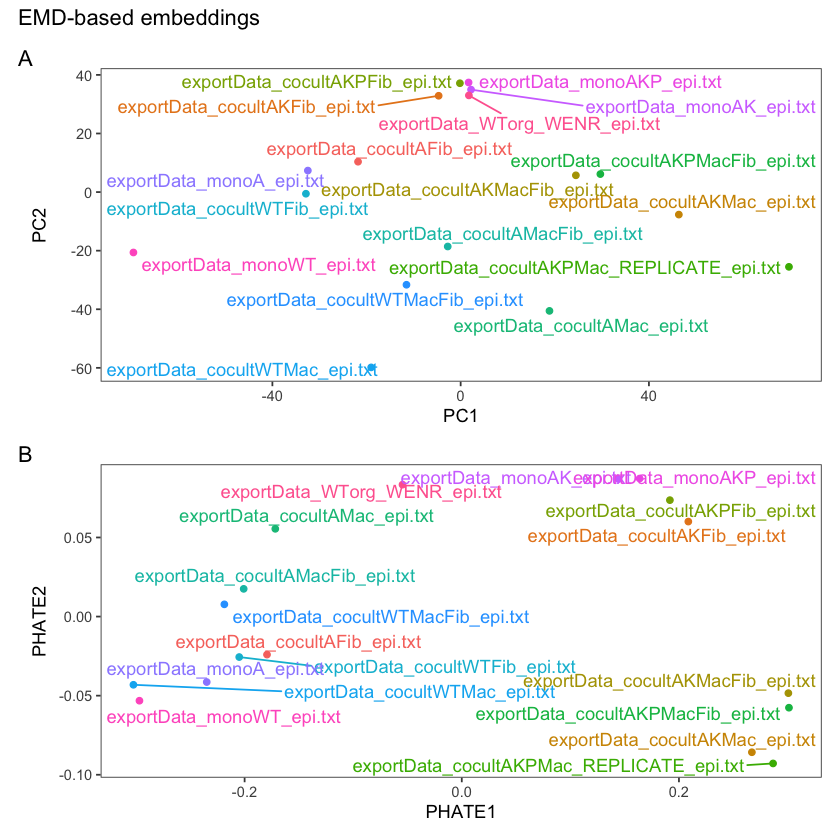

In [21]:
pca_plot + phate_plot + 
plot_layout(ncol=1, nrow = 2) +
plot_annotation(title="EMD-based embeddings",
    tag_levels = "A")

# cd34 pops effect on epi cells [Sup Fig1]

Section to generate and plot DE Htmp of fibro effect on WT organoids.

The aim is to compare and show no diffs between CD34 high and low fibroblasts (in terms of their effect on the transcriptional profile of WT organoids).

In [22]:
#Load full object from DATA REPO

    INTepi <- readRDS(paste0(data_dir, "INTepi.rds"))

In [23]:
#Load downsampled object from github

    downsampled_INTepi <- readRDS("data/downsampled_INTepi.rds")

In [24]:
#Keep only non-outlier clusters

    INTepi <- subset(INTepi, 
        subset=curatedCLUST != "Outlier 1 (Stressed?)" &
            curatedCLUST !="Outlier 2 (CRC?)" &
            orig.ident %in% c("monoWT","WTorg_mono","cocultWTFib","WTorg_CD34hilo",
                "WTorg_CD34hi","WTorg_CD34lo")
                    )
    levels(droplevels(INTepi@meta.data$curatedCLUST))
    levels(droplevels(INTepi@meta.data$orig.ident))
    INTepi

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca_epi_ to pcaepi_"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_epi_ to umapepi_"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from phate_epi_ to phateepi_"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from phate_epi2_ to phateepi2_"


[1] "CSC"              "proCSC"           "revCSC"           "TA 1"            
[5] "TA 2"             "ER Stress"        "Goblet / DCS"     "Early Enterocyte"
[9] "Late Enterocyte"

[1] "monoWT"         "WTorg_mono"     "cocultWTFib"    "WTorg_CD34hilo"
[5] "WTorg_CD34hi"   "WTorg_CD34lo"

An object of class Seurat 
84714 features across 8082 samples within 4 assays 
Active assay: RNA (27434 features, 0 variable features)
 3 other assays present: SCT, integrated, UCellRanks
 7 dimensional reductions calculated: pca, umap, phate, pca_epi, umap_epi, phate_epi, phate_epi2

In [25]:
#Load genelist from csv file
EPI_geneSet <- read_csv("../Data/CuratedEpithelia_geneSet.csv")
EPI_geneSet

Rows: 59 Columns: 2
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (2): GENE, ANNOTATION

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


GENE,ANNOTATION
<chr>,<chr>
Lgr5,CSC
Pla2g2a,CSC
Lrig1,CSC
Smoc2,CSC
Aqp5,CSC
Agr2,CSC
Cenpa,proCSC
Hmgb2,proCSC
Birc5,proCSC


In [26]:
mat_geneSet <- INTepi[["RNA"]]@scale.data[EPI_geneSet$GENE,] %>%
    as.matrix()

In [27]:
palette_seqrun <- c(
                    "First"="#ae00ff",
                    "Second"="#ff0000"
                    )
palette_cd34hi <- c(
                    "0"="#FFFFFF",
                    "1"="#ffd000"
                    )
palette_cd34lo <- c(
                    "0"="#FFFFFF",
                    "1"="#66ff00"
                    )

In [28]:
mdSEQ <- INTepi@meta.data %>%
                transmute(SEQ = case_when(
                    as.character.factor(orig.ident) %in% c(
                        "WTorg_mono","WTorg_CD34lo", "WTorg_CD34hi", "WTorg_CD34hilo"
                    ) ~ "Second",
                    TRUE ~ "First"
                ))
mdSEQ %>% group_by(SEQ) %>% summarise(n())

SEQ,n()
<chr>,<int>
First,1918
Second,6164


In [29]:
mdCD34 <- INTepi@meta.data %>%
                transmute(CD34hi = case_when(
                    as.character.factor(orig.ident) %in% c(
                        "WTorg_CD34hi", "WTorg_CD34hilo"
                    ) ~ "1",
                    as.character.factor(orig.ident) %in% c(
                        "WTorg_CD34lo"
                    ) ~ "0",
                                            ),
                CD34lo = case_when(
                    as.character.factor(orig.ident) %in% c(
                        "WTorg_CD34lo", "WTorg_CD34hilo"
                    ) ~ "1",
                    as.character.factor(orig.ident) %in% c(
                        "WTorg_CD34hi"
                    ) ~ "0",
                ))
mdCD34 %>% group_by(CD34hi, CD34lo) %>% summarise(n())

`summarise()` has grouped output by 'CD34hi'. You can override using the
`.groups` argument.


CD34hi,CD34lo,n()
<chr>,<chr>,<int>
0,1,1365
1,0,2464
1,1,1603
NA,NA,2650


In [30]:
INTepi <- AddMetaData(INTepi, metadata = c(mdSEQ, mdCD34))

In [31]:
htmp_anno <- HeatmapAnnotation(
                SEQ = INTepi@meta.data$SEQ,
                CD34hi = INTepi@meta.data$CD34hi,
                CD34lo = INTepi@meta.data$CD34lo,
                col=list(
                    SEQ = palette_seqrun,
                    CD34hi = palette_cd34hi,
                    CD34lo = palette_cd34lo
                ),
                na_col = "#FFFFFF"
)
htmp_anno

A HeatmapAnnotation object with 3 annotations
  name: heatmap_annotation_0 
  position: column 
  items: 8082 
  width: 1npc 
  height: 15.7029196070292mm 
  this object is subsettable
  15.1139333333333mm extension on the right 

   name annotation_type color_mapping height
    SEQ discrete vector  user-defined    5mm
 CD34hi discrete vector  user-defined    5mm
 CD34lo discrete vector  user-defined    5mm

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



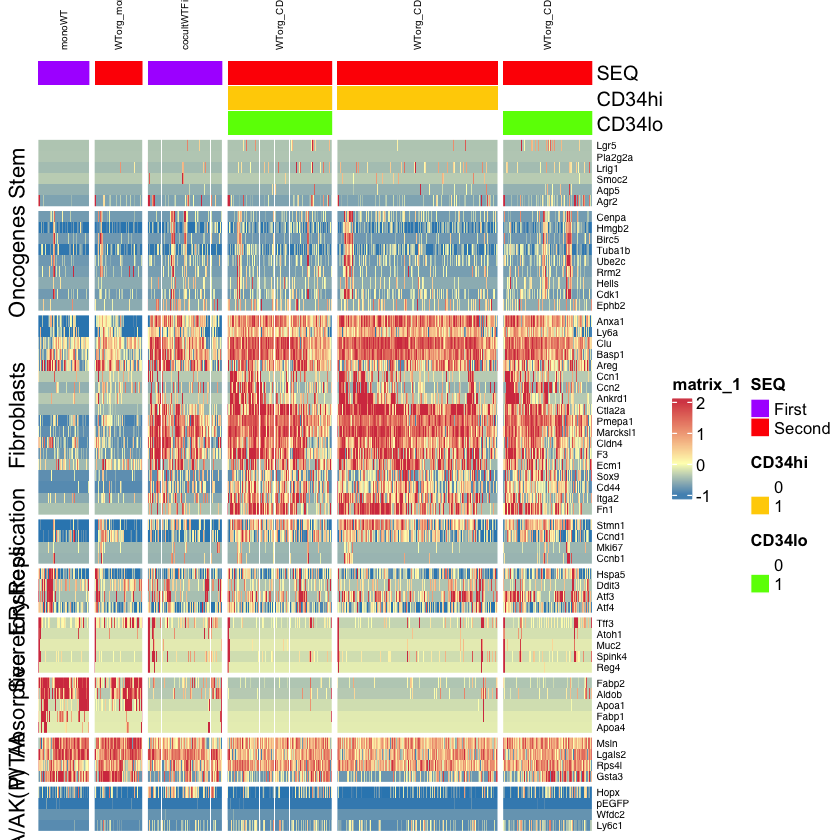

In [32]:
pHtmp_fibCD34_DEepi <- Heatmap(
        mat_geneSet,
        column_split = INTepi@meta.data$orig.ident,
        cluster_columns = TRUE, show_column_dend = FALSE, cluster_column_slices = FALSE,
        cluster_row_slices = FALSE, cluster_rows = FALSE,
        row_split = factor(
                        c(
                        rep("Stem", 6),
                        rep("Oncogenes", 9),
                        rep("Fibroblasts", 18),
                        rep("Replication", 4),
                        rep("ERstress", 4),
                        rep("Secretory", 5),
                        rep("Absorptive", 5),
                        rep("WT/A", 4),
                        rep("A/AK(P)", 4)
                        ),
                        levels = c(
                                "Stem","Oncogenes", "Fibroblasts", 
                                "Replication", "ERstress", 
                                "Secretory", "Absorptive",
                                "WT/A", "A/AK(P)"
                                )
                        ),
        row_names_gp = gpar(fontsize=6, fontfamily="Helvetica"),
        column_title_rot = 90, column_title_gp = gpar(fontsize=6),
        column_gap = unit(1.2, "mm"), show_column_names = FALSE,
        top_annotation = htmp_anno,
        use_raster = TRUE, raster_quality = 4,
        col=circlize::colorRamp2(
                c(round(quantile(mat_geneSet, c(0.04,0.96))[1], digits = 1),
                0, 
                round(quantile(mat_geneSet, c(0.04,0.96))[2], digits = 1)), 
                c("#3288BD", "#FEFEBD", "#D53E4F"))
        )

pHtmp_fibCD34_DEepi

<!-- WIP: Still need to consolidate nomenclature (SEQ->Run, ...) -->